# Data generation
To generate our datasets we used a parser created by an epfl professor: François Fleuret. On the site he writes the consent for academic use.

In [1]:
import torch
from torchvision import datasets

import argparse
import os

import urllib

######################################################################
#THIS PARSER IS TAKEN FROM THE WEBSITE: https://fleuret.org/dlc/
#We use it to simply generate our data sets containig pairs of Mnist images with digit labels and testclasses
######################################################################

parser = argparse.ArgumentParser(description='DLC prologue file for practical sessions.')

parser.add_argument('--full',
                    action='store_true', default=False,
                    help='Use the full set, can take ages (default False)')

parser.add_argument('--tiny',
                    action='store_true', default=False,
                    help='Use a very small set for quick checks (default False)')

parser.add_argument('--seed',
                    type=int, default=0,
                    help='Random seed (default 0, < 0 is no seeding)')

parser.add_argument('--cifar',
                    action='store_true', default=False,
                    help='Use the CIFAR data-set and not MNIST (default False)')

parser.add_argument('--data_dir',
                    type=str, default=None,
                    help='Where are the PyTorch data located (default $PYTORCH_DATA_DIR or \'./data\')')

# Timur's fix
parser.add_argument('-f', '--file',
                    help='quick hack for jupyter')

args = parser.parse_args()

if args.seed >= 0:
    torch.manual_seed(args.seed)


######################################################################
# The data

def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp


def load_data(cifar=None, one_hot_labels=False, normalize=False, flatten=True):
    if args.data_dir is not None:
        data_dir = args.data_dir
    else:
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'

    if args.cifar or (cifar is not None and cifar):
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train=True, download=True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train=False, download=True)

        train_input = torch.from_numpy(cifar_train_set.data)
        train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        train_target = torch.tensor(cifar_train_set.targets, dtype=torch.int64)

        test_input = torch.from_numpy(cifar_test_set.data).float()
        test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        test_target = torch.tensor(cifar_test_set.targets, dtype=torch.int64)

    else:
        print('* Using MNIST')

        ######################################################################
        # import torchvision

        # raw_folder = data_dir + '/mnist/raw/'
        # resources = [
        # ("https://fleuret.org/dlc/data/train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        # ("https://fleuret.org/dlc/data/train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        # ("https://fleuret.org/dlc/data/t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        # ("https://fleuret.org/dlc/data/t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
        # ]

        # os.makedirs(raw_folder, exist_ok=True)

        # # download files
        # for url, md5 in resources:
        # filename = url.rpartition('/')[2]
        # torchvision.datasets.utils.download_and_extract_archive(url, download_root=raw_folder, filename=filename, md5=md5)
        ######################################################################

        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train=True, download=True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train=False, download=True)

        train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.targets
        test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.targets

    if flatten:
        train_input = train_input.clone().reshape(train_input.size(0), -1)
        test_input = test_input.clone().reshape(test_input.size(0), -1)

    if args.full:
        if args.tiny:
            raise ValueError('Cannot have both --full and --tiny')
    else:
        if args.tiny:
            print('** Reduce the data-set to the tiny setup')
            train_input = train_input.narrow(0, 0, 500)
            train_target = train_target.narrow(0, 0, 500)
            test_input = test_input.narrow(0, 0, 100)
            test_target = test_target.narrow(0, 0, 100)
        else:
            print('** Reduce the data-set (use --full for the full thing)')
            train_input = train_input.narrow(0, 0, 1000)
            train_target = train_target.narrow(0, 0, 1000)
            test_input = test_input.narrow(0, 0, 1000)
            test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target


######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size=2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes


######################################################################

def generate_pair_sets(nb):
    if args.data_dir is not None:
        data_dir = args.data_dir
    else:
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train=True, download=True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST(data_dir + '/mnist/', train=False, download=True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    train_input, train_target, train_classes = mnist_to_pairs(nb, train_input, train_target)
    test_input, test_target, test_classes = mnist_to_pairs(nb, test_input, test_target)

    train_input, test_input = standardize(train_input, test_input)
    # train_input, test_input = normalize_min_max(train_input, test_input)
    return train_input, train_target, train_classes, test_input, test_target, test_classes


######################################################################

def standardize(train_input, test_input):
    """ Standardize the data using mean and standard deviations """
    mean = train_input.mean()
    std = train_input.std()

    return (train_input - mean) / std, (test_input - mean) / std


def normalize_min_max(train_input, test_input):
    """ normalize using min max """
    min_ = train_input.min()
    max_min = train_input.max() - min_
    return (train_input - min_) / max_min, (test_input - min_) / max_min

# Optimization for machine learning project: Can we learn the learning rate?
The goal of this project is to understand if it is possible to learn the learning-rate. To do this we have chosen a problem, given two images taken from MNIST dataset, to recognize which of the two is larger. To have a slightly wider result, we decided to create 2 models with different architectures. A neural network that uses Auxiliary loss, and ultimately a convolutional neural network.
The ultimate goal is to study how various learning-rate tuning methods behave on these various architectures. The optimization methods studied are grid_search, radom_search, baeyian optimization, neuralnetwork tuning, and an evolutionary method.
To study the various characteristics of the optimizers we will evaluate the convergence speed (how long it takes to find a learning rate that performs at a certain precision) and the maximum (average) precision achieved. Finally, we will compare our results to our expectations (theory).

## 1) Data import

In [ ]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

## 2) Model creation

# First model: NN using Auxiliary loss to help the learning. 
At an intermediary layer we try to classify the immages
In the final layer we try to Understand which one contains a bigger digit


In [2]:
from torch import nn
from torch.nn import functional as F
from torch import optim

In [3]:
import cmath

import matplotlib.pyplot as plt


class ModelResult:
    """ Encapsulates the the different error rates and losses of a model """

    def __init__(self, result_id, train_err_rates, test_err_rates, losses):
        self.id = result_id
        self.train_err_rates = train_err_rates
        self.test_err_rates = test_err_rates
        self.losses = losses


# --------------------------------------------------------------------------------#

colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple',
          'tab:yellow', 'tab:black', 'tab:skyblue', 'tab:chocolate', 'tab:lawngreen']


def plot_models_results_comparison(model_results, nb_rounds, means_only=False):
    """ Plot all the models performances statistics (images are saved in "results" folder """
    if not means_only:
        plot_train_err_rates(model_results, nb_rounds)
        plot_test_err_rates(model_results, nb_rounds)

    plot_train_err_rates_means(model_results)
    plot_test_err_rates_means(model_results)
    plot_losses(model_results)


def plot_model_result(model_result, nb_rounds):
    """ Plot the statistics for a single model (images are saved in "results" folder) """

    plot_single_model_train_test_err_rates_comparison(model_result, nb_rounds)
    plot_losses([model_result])


# --------------------------------------- Local Use ---------------------------------------#

def plot_train_err_rates(model_results, nb_rounds):
    """ Plot the train error rates of the models in a single chart """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Round', labelpad=nb_rounds)
    ax.set_ylabel('Train error rate')

    max_err_rate = max([max(mod_res.train_err_rates) for mod_res in model_results])
    ax.set_ylim([0, max_err_rate + 0.05 * max_err_rate])

    for i, mod_res in enumerate(model_results):
        ax.plot(mod_res.train_err_rates, color=colors[i % len(colors)], label=mod_res.id)
    ax.legend()

    #plt.savefig("results/train_err" + concat_models_names(model_results) + ".png")
    plt.show()


def plot_train_err_rates_means(model_results):
    """ Plot the train error rates of the models in a single chart """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_ylabel('Train error rate')

    names = [mod_res.id for mod_res in model_results]
    means = [mean(mod_res.train_err_rates) for mod_res in model_results]
    stds = [std(mod_res.train_err_rates) for mod_res in model_results]

    ax.bar(names, means, color=colors[0:len(model_results)], yerr=stds, capsize=4)

    #plt.savefig("results/train_err_avg" + concat_models_names(model_results) + ".png")
    plt.show()


def plot_test_err_rates(model_results, nb_rounds):
    """ Plot the test error rates of the models in a single chart """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Round', labelpad=nb_rounds)
    ax.set_ylabel('Test error rate')

    max_err_rate = max([max(mod_res.test_err_rates) for mod_res in model_results])
    ax.set_ylim([0, max_err_rate + 0.05 * max_err_rate])

    for i, mod_res in enumerate(model_results):
        ax.plot(mod_res.test_err_rates, color=colors[i % len(colors)], label=mod_res.id)
    ax.legend()

   # plt.savefig("results/test_err" + concat_models_names(model_results))


def plot_test_err_rates_means(model_results):
    """ Plot the train error rates of the models in a single chart """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_ylabel('Test error rate')

    names = [mod_res.id for mod_res in model_results]
    means = [mean(mod_res.test_err_rates) for mod_res in model_results]
    stds = [std(mod_res.test_err_rates) for mod_res in model_results]

    for k in zip(means, stds):
        print(k[0], " ", k[1])
    print()

    ax.bar(names, means, color=colors[0:len(model_results)], yerr=stds, capsize=4)

    #plt.savefig("results/test_err_avg" + concat_models_names(model_results) + ".png")
    plt.show()


def plot_single_model_train_test_err_rates_comparison(model_result, nb_rounds):
    """ Plot the test and train error rates for a single model """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Round', labelpad=nb_rounds)
    ax.set_ylabel('Error rate')

    max_err_rate = max(max(model_result.train_err_rates), max(model_result.test_err_rates))
    ax.set_ylim([0, max_err_rate + 0.05 * max_err_rate])

    ax.plot(model_result.train_err_rates, color=colors[0], label="train")
    ax.plot(model_result.test_err_rates, color=colors[1], label="test")
    ax.legend()

    #plt.savefig("results/train_test_err" + model_result.id)
    plt.show()


def plot_losses(model_results):
    """ Plot the loss evolution """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')

    max_err_rate = max([max(mod_res.losses) for mod_res in model_results])
    ax.set_ylim([0, max_err_rate + 0.05 * max_err_rate])

    for i, mod_res in enumerate(model_results):
        ax.plot(mod_res.losses, color=colors[i % len(colors)], label=mod_res.id)
    ax.legend()

    #plt.savefig("results/losses_evolution" + concat_models_names(model_results))
    plt.show()


def concat_models_names(model_results):
    name = ""
    for mod_res in model_results:
        name += "_" + mod_res.id
    return name


def mean(values):
    return sum(values) / len(values)


def std(values):
    if len(values) == 0:
        return 0

    mean_ = mean(values)
    variance = sum([(v - mean_) ** 2 for v in values]) / (len(values) - 1)
    return cmath.sqrt(variance).real

In [4]:
from abc import abstractmethod

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim


class Model(nn.Module):
    """ A deep network with the added capability to train itself and provide
        statistics about the training and testing performances.

        Attributes
        ----------
        sets_size : int
            the size of both the training and the testing sets

        useAuxiliary : Boolean
            determines if the model uses auxiliary loss or not

        f_gen_data : function
            a function taking a an int and generating the training and testing data

        epochs, batch_size, lr, l2 : hyper-parameters

        Methods
        -------
        train_and_test_round() :
            generates new data, train itself and compute performance statistics.

        train_and_test_rounds(nb_rounds) :
            does nb_rounds iteration of train_and_test_round
    """

    sets_size = 1000

    def __init__(self, f_gen_data, nb_epochs=25, mini_batch_size=100, learning_rate=5e-3, l2_rate=0):
        super(Model, self).__init__()
        self.generate_data = f_gen_data
        self.epochs = nb_epochs
        self.batch_size = mini_batch_size
        self.lr = learning_rate
        self.l2 = l2_rate

    @abstractmethod
    def reset(self):
        """ Reinitialize the weights of the model, need to be redefined"""



In [5]:
class Auxiliary(Model):
    sets_size = 1000

    def __init__(self, f_gen_data, nb_epochs=25, mini_batch_size=100, learning_rate=1e-3,
                 l2_rate=0.1):
        super().__init__(f_gen_data, nb_epochs, mini_batch_size, learning_rate, l2_rate)


        # layer 1
        self.fc1 = nn.Linear(196, 160)
        self.bn1 = nn.BatchNorm1d(160)
        self.drop1 = nn.Dropout(0.5)

        # layer 2
        self.fc2 = nn.Linear(80, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.drop2 = nn.Dropout(0.5)

        # layer 3 : digit classification
        self.fc3 = nn.Linear(50, 10)

        # layer 4 : digit comparison
        self.fc4 = nn.Linear(20, 2)
        #print(sum(p.numel() for p in self.parameters() if p.requires_grad))

    def reset(self,learningrate = None):
        if learningrate == None:
            self.__init__(self.generate_data, self.epochs, self.batch_size, self.lr, self.l2)
        else:
            self.__init__(self.generate_data, self.epochs, self.batch_size, learningrate, self.l2)

    def train_and_test(self):
#             The model runs a complete "round" consisting of the following steps :
#             1. Generate new train and test data
#             2. Trains with the new generated data
#             3. Compute the train and test error rates and other performance statistics
        

        train_input, train_target, train_classes, \
            test_input, test_target, test_classes = self.generate_data(self.sets_size)

        # one channel with the original channel's images in alternation
        train_input = train_input.view(-1, 1, 14, 14)
        train_classes = train_classes.view(-1)
        test_input = test_input.view(-1, 1, 14, 14)
        test_classes = test_classes.view(-1)

        losses = self._train(train_input, train_target, train_classes)
        train_err_rate = self._compute_errors(train_input, train_target)
        test_err_rate = self._compute_errors(test_input, test_target)

        return train_err_rate, test_err_rate, losses

    def _train(self, train_input, train_target, train_classes):
        #Train the model 
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), self.lr)

        losses = []

        for e in range(self.epochs):
            for b in range(0, train_input.size(0), self.batch_size):

                # if use auxiliary loss, add both digit classification and comparison loss
                
                digit_class, final_class = self(train_input.narrow(0, b, self.batch_size))
                loss = \
                    criterion(
                        # loss for digit classification
                        digit_class,
                        train_classes.narrow(0, b, self.batch_size)
                    ) + criterion(
                        # loss for comparison
                        final_class,
                        # need to divide by two, because one iteration in the network does
                        # two times less comparisons (single channel)
                        train_target.narrow(0, b // 2, self.batch_size // 2)
                    )


                # L2 penalty
                for p in self.parameters():
                    loss += self.l2 * p.pow(2).sum()

                self.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.data.item())

        return losses

    # --- Private methods --- #

    def _compute_errors(self, data_input, data_target):
        #Computes the number of errors produced by the model 
        nb_data_errors = 0

        for b in range(0, data_input.size(0), self.batch_size):

            output = self(data_input.narrow(0, b, self.batch_size))


            output = output[1]

            _, predicted_classes = torch.max(output, 1)

            target_b = b // 2
            target_batch_size = self.batch_size // 2

            for k in range(target_batch_size):
                if data_target[target_b + k] != predicted_classes[k]:
                    nb_data_errors = nb_data_errors + 1

        return 100 * nb_data_errors / data_input.size(0)
    

    def forward(self, x):
        n = x.size()[0]

        # layer 1
        x = F.relu(self.bn1(self.fc1(x.view(n, -1))))
        x = F.max_pool1d(x.view(n, 1, -1), kernel_size=2)
        x = self.drop1(x)

        # layer 2
        x = F.relu(self.bn2(self.fc2(x.view(n, -1))))
        x = F.max_pool1d(x.view(n, 1, -1), kernel_size=2)
        x = self.drop2(x)

        # layer 3 : digit classification
        digit_class = self.fc3(x.view(n, -1))
        x = F.relu(digit_class)

        # layer 4 : digit comparison
        final_class = self.fc4(x.view(x.size()[0] // 2, -1))
        return digit_class, final_class

In [6]:
def train_and_test_rounds(model, nb_rounds, test_id,learningrate ):
#         Complete nb_rounds iterations of train_and_test and returns the train and test error
#         rates and other performance statistics in an ModelResult object

#         Parameter
#         ---------
#         nb_rounds : int
#             the number of round

#         Returns
#         -------
#         a ModelResult object containing the overall rounds performance statistics
    

    trains_err_rates = []
    tests_err_rates = []
    losses = []
    
    for i in range(nb_rounds):
        model.reset(learningrate)
        model.train()
        for layer in model.children():
          if hasattr(layer,'reset_parameters'):
            layer.reset_parameters()
        #print(model._compute_errors(test_input, test_target) )
        trains_err_rate, tests_err_rate, losses_ = model.train_and_test()
        trains_err_rates.append(trains_err_rate)
        tests_err_rates.append(tests_err_rate)
        losses.append(losses_)

    loss_it = len(losses[0])
    loss_avg = []
    for i in range(loss_it):
        loss_avg.append(mean(list(map(lambda ls: ls[i], losses))))
    # print('trains_err_rates: ', trains_err_rates)
    # print('tests_err_rates: ', tests_err_rates)
    # print('loss_avg: ', loss_avg)
    return ModelResult(test_id, trains_err_rates, tests_err_rates, loss_avg)


# def main():
#     number_rounds = 10
#     model = "Auxiliary"
#     model2 = Auxiliary(generate_pair_sets)
#     mRes2 = train_and_test_rounds(model2, number_rounds, "Auxiliary")
#     #plot_model_result(mRes2, number_rounds)
    

# if __name__ == '__main__':
#     main()

## 3) Learning rate optimization techniques

In [7]:
# imports

from keras.datasets import mnist
from keras.optimizers import SGD
from matplotlib import pyplot
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy.random import seed
import tensorflow 
import time
from scipy import optimize
import random


# First method: grid search sampling N points of an interval (rangemin,rangemax) then choosing the learning rate that minimize the loss.

In [8]:
def return_accuracy(learningrate):
    number_rounds = 1
    model = "Auxiliary"
    model2 = Auxiliary(generate_pair_sets)
    mRes2 = train_and_test_rounds(model2, number_rounds, "Auxiliary",learningrate)
    print("here",sum(mRes2.test_err_rates)/len(mRes2.test_err_rates))
    return (100 - sum(mRes2.test_err_rates)/len(mRes2.test_err_rates))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


here 21.7
here 10.0
here 7.9
here 8.8
here 9.75
here 8.75
here 9.0
here 9.6
here 7.8
here 9.45
here 10.15
(92.2, 0.00242)
total computation time =  49.29277849197388


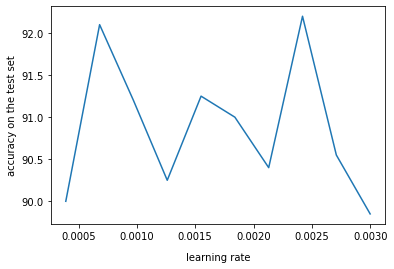

In [9]:
#admitting that the range is the somehow known good learnig rate range (0.1-1)

def Grid_search(ranges, function, Npoints):
    Npoints +=1
    convergencex = []
    convergencey = []
    x_vals = []
    maxaccuracy = 0
    minval = 0
    for i in range(Npoints):
        x_vals.append(ranges[0]+(ranges[1]-ranges[0])*i/(Npoints-1))
    number  = 0
    for value in x_vals:
        number += 1
        tmp = function(value)
        convergencex.append(value)
        convergencey.append(tmp)
        if (tmp > maxaccuracy):
            maxaccuracy = tmp
            minval = value
    #plot convergence
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('learning rate', labelpad=Npoints)
    ax.set_ylabel('accuracy on the test set' )
    convergencex.pop(0)
    convergencey.pop(0)
    ax.plot(convergencex,convergencey)
    return (maxaccuracy,minval)


rangemaxmin = (0.0001,0.003)
start = time.time()
print(Grid_search(rangemaxmin,return_accuracy,10))
end = time.time()
print('total computation time = ', (end-start) )

# Second method: Random search sampling N points of an interval (rangemin,rangemax) then choosing the learning rate that minimize the loss.

here 22.4
here 29.6
here 8.85
here 23.5
here 21.8
here 22.45
here 21.55
here 23.05
here 22.4
here 21.4
x = lr =  [0.0012305829710922715, 0.11538323425993233, 0.1487760537843668, 0.15703255072717603, 0.20065922778456202, 0.21630241938606312, 0.298293887819877, 0.3390736470200846, 0.34352317755226663, 0.3767305417467151]
y = error =  [91.15, 78.2, 76.95, 77.6, 76.5, 78.6, 77.55, 70.4, 77.6, 78.45]
(91.15, 0.0012305829710922715)
total computation time =  37.43556547164917


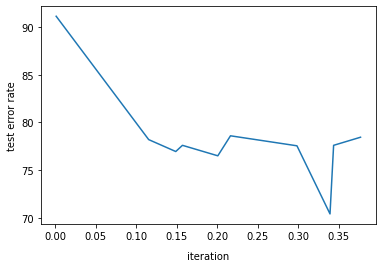

In [10]:
#admitting that the range is the somehow known good learnig rate range (0.1-1)
#basically a grid of random points
def Grid_search_random(ranges, function, Npoints):
    convergencex = []
    convergencey = []
    x_vals = []
    maxaccuracy = 0
    minval = 0
    for i in range(Npoints):
        x_vals.append(ranges[0]+(ranges[1])*(random.uniform(ranges[0],ranges[1])/ranges[1]))


    number  = 0
    for value in x_vals:
        number += 1
        tmp = function(value)
        convergencex.append(value)
        convergencey.append(tmp)
        if (tmp > maxaccuracy):
            maxaccuracy = tmp
            minval = value
    #plot convergence
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    zipped_lists = zip(convergencex, convergencey)
    sorted_zipped_lists = sorted(zipped_lists)
    sorted_listy = [element for _, element in sorted_zipped_lists]
    ax.set_xlabel('iteration', labelpad=Npoints)
    ax.set_ylabel('test error rate')
    print('x = lr = ',sorted(convergencex))
    print('y = error = ',sorted_listy)
    ax.plot(sorted(convergencex),sorted_listy)
    return (maxaccuracy,minval)


rangemaxmin = (0.000001,0.4)

start = time.time()
print(Grid_search_random(rangemaxmin,return_accuracy,10))
end = time.time()
print('total computation time = ', (end-start) )

here 21.65
here 9.45
here 18.35
here 9.6
here 10.3
here 21.6
here 9.45
here 9.8
here 9.6
here 25.2
here 8.95
here 9.1
here 10.7
here 9.85
here 18.7
here 9.6
here 9.4
here 9.5
here 9.9
here 10.95
here 15.75
here 9.4
here 8.7
here 8.5
here 10.2
here 9.35
here 10.5
here 20.55
here 8.75
here 8.65
here 8.05
here 10.2
here 8.45
here 9.15
here 11.35
here 19.75
here 9.15
here 8.2
here 8.65
here 9.05
here 9.8
here 8.15
here 9.6
here 10.65
here 20.85
here 11.05
here 8.85
here 8.85
here 9.3
here 8.75
here 9.0
here 10.2
here 8.95
here 10.5
here 16.15
here 10.45
here 9.65
here 7.4
here 8.8
here 9.35
here 9.0
here 8.35
here 10.05
here 9.35
here 9.9
optimal accuracy: 92.6 optimal learning rate:  10


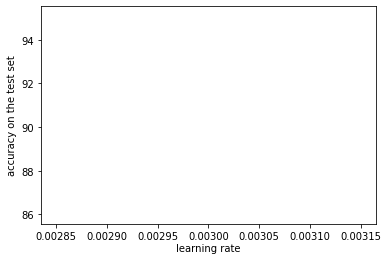

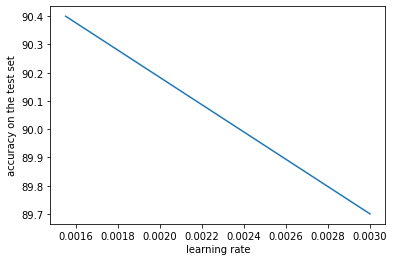

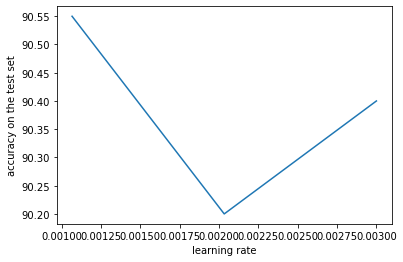

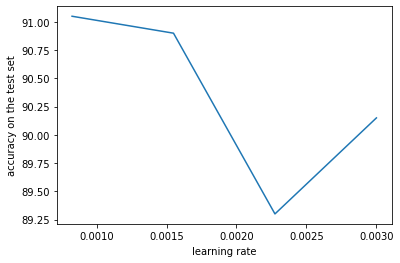

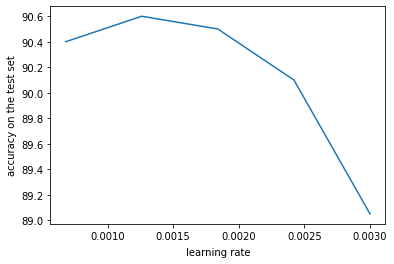

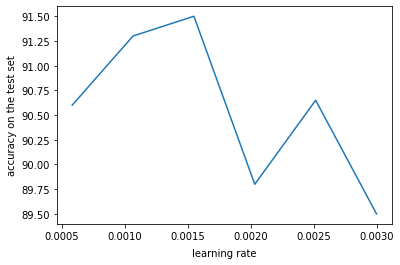

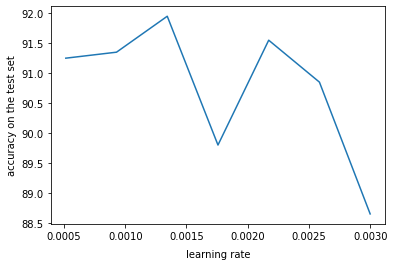

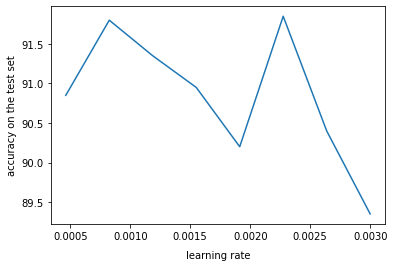

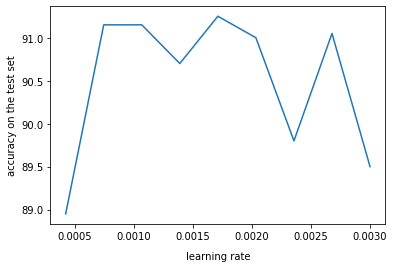

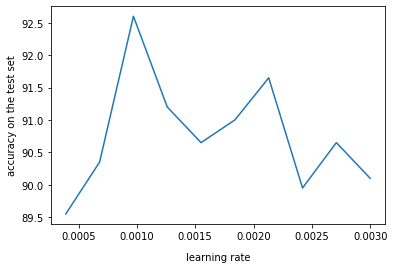

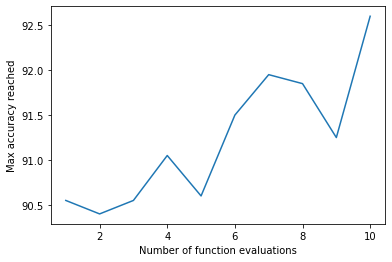

In [13]:
def PlotconvegenceinN(ranges,Nmax):
  Xls = []
  Yls = []
  acc = 0
  
  for i in range(Nmax):
    acc = Grid_search(ranges, return_accuracy, (i+1))[0]
    Xls.append(i+1)
    Yls.append(acc)
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel('Number of function evaluations')
  ax.set_ylabel('Max accuracy reached')
  ax.plot(Xls,Yls)
  maxacc = max(Yls)
  print("optimal accuracy:",maxacc,'optimal learning rate: ',Xls[Yls.index(maxacc)] )
ranges = (0.0001,0.003)
PlotconvegenceinN(ranges,10)


## 4) Different keras optimizers + plotting


In [84]:
#to tranform if you want to use the keras optimizer => do a for loop and change the sign of the returned value!
default_parameters = [5*1e-4,7.5*1e-3,5*1e-2]
def fitness(lr):
  lr = float(lr)
  return return_accuracy(lr)
dim_learning_rate = Real(low=1e-4, high=3e-3, prior='log-uniform',
                         name='learning_rate')
dimensions = [dim_learning_rate]

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
!pip install scikit-optimize
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from tensorflow.python.keras import backend as K
import scipy.optimize as optimize
from scipy.optimize import Bounds

     |████████████████████████████████| 102kB 4.0MB/s 


In [82]:
gp_results = []
for default_lr in default_parameters:
    print("*****************************************************")
    print("Running optimizer for LR0: {0:.6}".format(default_lr))
    print("*****************************************************")
    gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=[default_lr])
    gp_results.append(gp_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
here 8.95


ValueError: ignored

In [61]:
gp_results[0].fun

-91.65

In [46]:


Nelder_Mead_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  Nelder_Mead_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='Nelder-Mead',
                                     options={'maxiter':10, 'maxfev':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,3e-3),))
  Nelder_Mead_results.append(Nelder_Mead_result)


*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


here 9.15
here 9.15
Optimization terminated successfully.
         Current function value: -90.850000
         Iterations: 1
         Function evaluations: 2
*****************************************************
Running optimizer for LR0: 0.0075
*****************************************************
here 12.9
here 12.9
here 11.55
here 13.4
here 13.45
here 11.95
here 12.7
here 13.1
here 11.5
here 12.9
here 13.05
here 13.25
*****************************************************
Running optimizer for LR0: 0.05
*****************************************************
here 23.0
here 21.65
here 21.8
here 23.25
here 22.55
here 23.1
here 26.65
here 22.4
here 22.6
here 21.2


In [65]:
Nelder_Mead_results

[       allvecs: [array([0.0005])]
 final_simplex: (array([[0.0005  ],
       [0.000525]]), array([-90.85, -90.85]))
           fun: -90.85
       message: 'Optimization terminated successfully.'
          nfev: 2
           nit: 1
        status: 0
       success: True
             x: array([0.0005]),
        allvecs: [array([0.0075]), array([0.007125]), array([0.007125]), array([0.00721875]), array([0.00721875])]
 final_simplex: (array([[0.00721875],
       [0.00717187]]), array([-88.5 , -86.75]))
           fun: -88.5
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 12
           nit: 5
        status: 1
       success: False
             x: array([0.00721875]),
        allvecs: [array([0.05]), array([0.0525]), array([0.0525]), array([0.0521875])]
 final_simplex: (array([[0.0521875],
       [0.0525   ]]), array([-78.8 , -78.35]))
           fun: -78.8
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev

x0: 0.0005 Learning-rate 0.0005087953629614591 Accuracy 91.65 %
x0: 0.0075 Learning-rate 0.0006319176590013172 Accuracy 90.4 %
x0: 0.05 Learning-rate 0.002657908837163809 Accuracy 91.05 %
x0: 0.0005 Learning-rate 0.0005 Accuracy 90.85 %
x0: 0.0075 Learning-rate 0.0072187499999999995 Accuracy 88.5 %
x0: 0.05 Learning-rate 0.052187500000000005 Accuracy 78.8 %


AttributeError: ignored

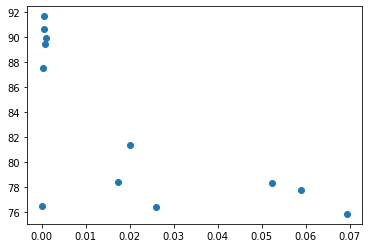

In [52]:
method_list = [gp_results,Nelder_Mead_results,L_BFGS_results,CG_results]
for method in method_list:
  for i in range(len(default_parameters)):
    print('x0:',default_parameters[i],'Learning-rate', method[i].x[0],'Accuracy', -method[i].fun,'%')
  
  plt.scatter([x for [x] in method[0].x_iters[:]],-1*method[0].func_vals[:])

In [27]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', gp_results[i].x[0],'Accuracy', -gp_results[i].fun,'%')

x0: 0.0005 Learning-rate 0.0005087953629614591 Accuracy 91.65 %
x0: 0.0075 Learning-rate 0.0006319176590013172 Accuracy 90.4 %
x0: 0.05 Learning-rate 0.002657908837163809 Accuracy 91.05 %


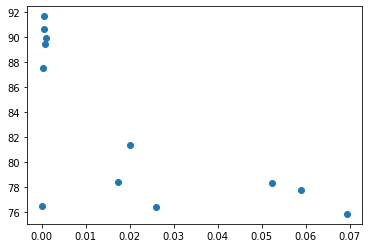

In [47]:
plt.xaxis('Accuracy')
plt.yaxis('Learning rate')
plt.scatter([x for [x] in gp_results[0].x_iters[:]],-1*gp_results[0].func_vals[:])


In [48]:
L_BFGS_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  L_BFGS_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='L-BFGS-B',
                                     options={'maxiter':10, 'maxfun':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,3e-3),))
  L_BFGS_results.append(L_BFGS_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method L-BFGS-B does not support the return_all option.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: return_all
  # Remove the CWD from sys.path while we load stuff.


here 11.4
here 10.3
here 10.0
here 9.7
here 8.85
here 9.2
here 8.55
here 9.15
here 10.0
here 9.6
here 10.85
here 10.05
here 10.2
here 10.55
*****************************************************
Running optimizer for LR0: 0.0075
*****************************************************
here 9.85
here 9.45
*****************************************************
Running optimizer for LR0: 0.05
*****************************************************
here 10.8
here 9.9


In [63]:
L_BFGS_results[0]


      fun: -89.8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([34999999.99999943])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 14
      nit: 1
   status: 1
  success: False
        x: array([0.000508])

In [49]:
CG_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  CG_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='CG',
                                     options={'maxiter':10, 'maxfeval':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,3e-3),))
  CG_results.append(CG_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


here 10.85
here 9.95
here 8.95
here 23.45
here 22.6
here 22.45
here 21.65
here 22.35
here 26.85
here 21.8
here 23.55
here 22.3
here 22.5
here 22.2
here 22.65
here 18.55
here 17.35
here 14.95
here 9.35
here 9.65
here 8.05
here 10.05
here 9.5
here 8.05
here 8.7
here 9.05
here 9.65
here 9.1
here 9.65
here 8.4
here 9.5
here 9.35
here 9.85
here 10.25
here 9.0
here 9.1
here 9.65
here 8.1
here 10.25
here 10.15
here 8.1
here 10.9
here 8.85
here 9.1
here 8.65
here 9.55
here 9.2
here 10.4
here 9.45
here 8.8
here 8.7
here 9.45
here 9.7
here 10.2
here 9.05
here 9.05
here 9.9
here 10.25
here 9.2
here 12.6
here 9.25
here 10.5
here 10.3
here 10.3
here 8.75
here 9.15
here 21.25
here 22.85
here 22.6
here 22.1
here 22.25
here 15.85
here 12.4
here 8.85
here 10.95
here 10.15
here 9.1
here 7.85
here 9.35
here 9.3
here 9.2
here 9.55
here 9.25
here 9.7
here 9.95
here 9.1
here 8.85
here 9.7
here 9.3
here 9.05
here 9.75
here 9.35
here 8.95
here 8.35
here 8.65
here 8.15
here 8.9
here 9.3
here 9.75
here 9.95
her

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


here 13.25
here 11.3
here 15.35
here 24.05
here 27.6
here 22.1
here 21.4
here 21.95
here 24.0
here 22.6
here 26.65
here 23.6
here 16.8
here 22.75
here 16.6
here 13.55
here 11.95
here 15.3
here 14.25
here 11.05
here 12.35
here 15.9
here 12.55
here 12.8
here 11.45
here 13.55
here 11.85
here 11.2
here 12.1
here 12.9
here 13.75
here 12.05
here 12.3
here 13.0
here 15.8
here 13.1
here 11.85
here 14.2
here 12.2
here 12.25
here 11.9
here 11.7
here 12.25
here 13.25
here 11.6
here 12.65
here 14.8
here 13.95
here 12.1
here 11.15
here 12.35
here 14.35
here 12.25
here 11.55
here 14.45
here 14.2
here 13.15
here 14.1
here 12.25
here 13.45
here 11.85
here 13.1
here 15.75
here 12.3
here 13.6
here 14.15
here 12.3
here 13.0
here 13.55
here 12.6
here 12.0
here 14.1
here 12.65
here 13.4
here 10.45
here 13.3
here 12.65
here 12.8
here 11.6
here 12.65
here 11.95
here 12.45
here 13.45
here 13.25
here 15.45
         Current function value: -87.750000
         Iterations: 1
         Function evaluations: 85
    

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


here 23.2
here 21.45
here 22.75
here 25.5
here 22.35
here 21.6
here 23.4
here 19.9
here 21.95
here 27.65
here 29.0
here 24.1
here 21.45
here 22.15
here 21.45
here 21.55
here 23.4
here 20.95
here 22.75
here 23.7
here 22.75
here 21.05
here 22.0
here 22.0
here 21.95
here 21.9
here 23.5
here 22.75
here 23.0
here 22.5
here 22.7
here 21.15
here 21.65
here 23.95
here 21.5
here 22.0
here 23.0
here 22.05
here 23.2
here 21.5
here 22.05
here 23.55
here 23.1
here 22.35
here 21.75
here 24.15
here 23.85
here 20.75
here 22.9
here 22.25
here 23.4
here 22.0
here 21.95
here 21.85
here 24.25
here 22.4
here 21.45
here 21.95
here 21.65
here 21.95
here 21.5
here 22.55
here 22.8
here 23.1
here 22.5
here 21.95
here 22.5
here 21.1
here 23.6
here 26.65
here 22.25
here 23.25
here 23.75
here 23.4
here 22.05
here 22.95
here 22.75
here 21.25
here 22.6
here 21.75
here 22.55
here 23.05
here 22.6
here 22.65
here 22.85
here 22.4
here 23.2
here 22.55
here 22.8
         Current function value: -78.000000
         Iterati

In [64]:
 CG_results

[ allvecs: [array([0.0005]), array([0.00061767])]
     fun: -92.15
     jac: array([-3355443.19999981])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 113
     nit: 1
    njev: 30
  status: 2
 success: False
       x: array([0.00061767]),
  allvecs: [array([0.0075]), array([0.00771694])]
     fun: -87.75
     jac: array([-13421772.80000019])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 85
     nit: 1
    njev: 25
  status: 2
 success: False
       x: array([0.00771694]),
  allvecs: [array([0.05]), array([0.05000066])]
     fun: -78.0
     jac: array([-6710886.40000057])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 89
     nit: 1
    njev: 26
  status: 2
 success: False
       x: array([0.05000066])]

In [50]:
COBYLA_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  COBYLA_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='COBYLA',
                                     options={'maxiter':10, 'maxfeval':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,3e-3),))
  COBYLA_results.append(COBYLA_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method COBYLA does not support the return_all option.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval, return_all
  # Remove the CWD from sys.path while we load stuff.


here 9.6
here 27.3


ValueError: ignored

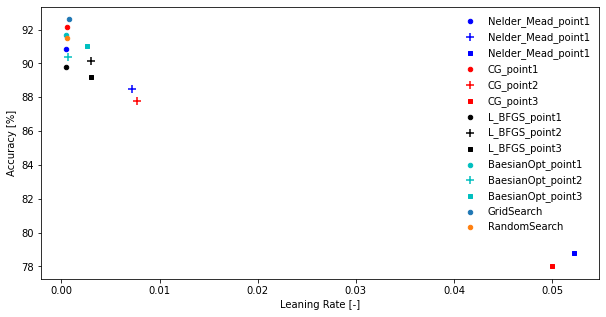

In [76]:
fig = plt.figure(figsize=(10,5))

plt.scatter(Nelder_Mead_results[0].x[0],-Nelder_Mead_results[0].fun,marker='o',c='b',s=20, label = 'Nelder_Mead_point1')

plt.scatter(Nelder_Mead_results[1].x[0],-Nelder_Mead_results[1].fun,marker='+',c='b',s=50, label = 'Nelder_Mead_point1')

plt.scatter(Nelder_Mead_results[2].x[0],-Nelder_Mead_results[2].fun,marker='s',c='b',s=20, label = 'Nelder_Mead_point1')

plt.scatter(CG_results[0].x[0],-CG_results[0].fun,marker='o',c='r',s=20, label = 'CG_point1')

plt.scatter(CG_results[1].x[0],-CG_results[1].fun,marker='+',c='r',s=50, label = 'CG_point2')

plt.scatter(CG_results[2].x[0],-CG_results[2].fun,marker='s',c='r',s=20, label = 'CG_point3')

plt.scatter(L_BFGS_results[0].x[0],-L_BFGS_results[0].fun,marker='o',c='k',s=20,label ='L_BFGS_point1')

plt.scatter(L_BFGS_results[1].x[0],-L_BFGS_results[1].fun,marker='+',c='k',s=50,label ='L_BFGS_point2')

plt.scatter(L_BFGS_results[2].x[0],-L_BFGS_results[2].fun,marker='s',c='k',s=20,label ='L_BFGS_point3')

plt.scatter(gp_results[0].x[0],-gp_results[0].fun,marker='o',c='c',s=20,label ='BaesianOpt_point1')

plt.scatter(gp_results[1].x[0],-gp_results[1].fun,marker='+',c='c',s=50,label ='BaesianOpt_point2')

plt.scatter(gp_results[2].x[0],-gp_results[2].fun,marker='s',c='c',s=20,label ='BaesianOpt_point3')

plt.scatter(0.000744,92.6,s=20,label ='GridSearch')
plt.scatter(0.000538,91.51666,s=20,label ='RandomSearch')


plt.xlabel('Leaning Rate [-]')

plt.ylabel('Accuracy [%]')
plt.legend(frameon = False)